import

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

The df

In [33]:
df = pd.read_csv(filepath_or_buffer=r"C:\Users\loulo\OneDrive\Bureau\test_technique\Voodoo_Case_Study_Game_Analyst.csv",
    parse_dates=['first_app_launch_date'],  # Parse the date column
) 

raw_df = df.copy()

# 1. EDA

In [34]:
df.drop_duplicates(inplace=True)
print(f"the dataframe has {len(df.columns)} columns and {len(df)} rows")
initial_len = len(df)

the dataframe has 22 columns and 1117679 rows


In [35]:
df.head()

,country,first_app_launch_date,fs_revenue,fs_watched,game_count,iap_revenue,iap_transactions,install_store,manufacturer,model,...,ad_revenue,rv_revenue,rv_watched,session_id,session_length,session_number,user_id,assigned_at,ab_test_name,cohort_name
0,GB,2024-10-14 20:03:02+00:00,0.103475,3,12,8.758466,1,NaN,Apple,iPhone14,...,0.154790,0.051315,1,c4ffdee2-af1b-4147-a12e-1be255e10f5a,771,102,0133f3a8-ff92-4c16-a029-2e2f4c624de0,2024-11-10 19:28:10.945000,v1.10 - Skipits - Existing Users,Control
1,US,2024-11-15 05:15:18+00:00,0.237131,9,63,7.990000,1,NaN,Apple,iPhone15Pro,...,0.237131,NaN,0,3e1de1f7-aa37-4146-8511-ce80fa9b4a5e,2312,12,02330e6e-e06b-4722-89bb-6392ea6734f4,2024-11-15 05:15:25.016000,v1.10 - Skipits - New Users,Skipits - Middle Prices
2,US,2024-11-05 06:16:15+00:00,NaN,0,71,12.990000,1,com.android.vending,samsung,SM-S926U,...,0.000000,NaN,8,c42f58c0-d3bc-4eaf-89be-3c23d5bea7b6,4221,85,0240b6c2-3dcb-4104-9146-a49f3f9418ca,2024-11-09 06:53:41.435000,v1.10 - Skipits - Existing Users,Skipits - Middle Prices
3,IN,2024-09-26 17:49:25+00:00,0.010450,16,74,5.332806,1,com.android.vending,samsung,SM-S918B,...,0.019242,0.008792,1,c780a188-9919-4d56-bb37-f4f0dae06cb6,3573,323,0245fea7-aac4-4430-9b56-3e63507d820c,2024-11-12 17:26:52.479000,v1.10 - Skipits - Existing Users,Skipits - High Prices
4,US,2024-10-23 17:44:11+00:00,0.054266,1,9,9.990000,1,NaN,Apple,iPhone15Pro,...,0.237337,0.183071,4,2022690b-17e2-4bc4-ae6c-ad396b05b5e6,918,31,02dbff9f-1136-4889-aef5-74ea908bc7d5,2024-11-10 23:38:28.594000,v1.10 - Skipits - Existing Users,Control


## A. Country
No real insight here

In [36]:
df["country"].value_counts()

US    288608
JP    107950
DE     45872
GB     44347
BR     39567
       ...  
ST         1
LR         1
SB         1
NF         1
NR         1
Name: country, Length: 229, dtype: int64

## B. first_app_launch_date
There are abnormal values at both end, future and past. I'll delete the rows outside of the current date and launching of the game. 

In [37]:
print( f"Launching dates ranges from {df['first_app_launch_date'].min()} to {df['first_app_launch_date'].max()}")

Launching dates ranges from 2001-01-24 19:29:12+00:00 to 2029-01-19 18:22:46+00:00


In [38]:
mask = (df['first_app_launch_date'] > '2023-1-1') & (df['first_app_launch_date'] <= '2025-10-5')
df = df.loc[mask]
df.reset_index(
    inplace=True, 
    drop=True,
    )
print(f"the dataframe has {len(df.columns)} columns and {len(df)} rows. Deleted {initial_len - len(df)} rows")

the dataframe has 22 columns and 1117651 rows. Deleted 28 rows


## C. fs_revenue, fs_watched
Many null records in revenue, we can't fill them out with linear interpolation so I fill with the median. Since player have revenues even with 0 fs_wached i don't think they should be understood as 0. 
Currency could be euros or cents, since the highest value is 0.025. I do not know the order of magnitude. 

In [39]:
print(f"there are {len(df[df['fs_revenue'].isna()])} null records in fs_revenue and {len(df[df['fs_watched'].isna()])} null recs in fs_watched")

# Let's check if the nulls are problematic (ie not replaceble by 0, because fs_watched is not 0 
print(sum(df[(df['fs_revenue'].isna()) & (df['fs_watched']>0)]['fs_watched'].value_counts()))
# Indeed, few thousands records with a problematic nan 

# We check if there is a clear linear correlation for backfilling may be 
filtered_df = df[df['fs_revenue'].notnull()]
correlation = filtered_df[['fs_watched', 'fs_revenue']].corr().iloc[0, 1]
print(f"Pearson correlation: {correlation:.4f}")

# There aren't any, we can't delete 496019 null recs we will backfill with the median
revenue_medians = df.groupby("fs_watched")["fs_revenue"].median()

df["fs_revenue"] = df.apply(
    lambda row: revenue_medians[row['fs_watched']] if pd.isna(row['fs_revenue']) and row['fs_watched'] in revenue_medians else 0,    axis=1
)

there are 496018 null records in fs_revenue and 0 null recs in fs_watched
8533
Pearson correlation: 0.2878


In [40]:
print(f"there are now {len(df[df['fs_revenue'].isna()])} null records in fs_revenue and {len(df[df['fs_watched'].isna()])} null recs in fs_watched")
print(f"the minimal value is {df['fs_revenue'].min()}, which is coherent. Max is {df['fs_revenue'].max()}")

there are now 0 null records in fs_revenue and 0 null recs in fs_watched
the minimal value is 0.0, which is coherent. Max is 0.0251592611121563


## D. game_count
No real insights here. The distribution is slightly unexpected, with first 0 and then 15 instead of 1. Could be the number of games played for a session.

In [41]:
df[df["game_count"].isna()]
print(f"there are {len(df[df['game_count'].isna()])} null records")
print(df["game_count"].value_counts())

there are 0 null records
0      131585
15      65026
1       48115
2       36504
16      34147
        ...  
400         1
544         1
867         1
535         1
821         1
Name: game_count, Length: 584, dtype: int64


## E. iap_revenue, iap_transactions
There are no missing values and the miinimum value is coherent. the amount seem fairly high, could be in cents but we will keep it that way for now. 

In [42]:
print(f"there are {len(df[df['iap_revenue'].isna()])} null records in iap_revenue and {len(df[df['iap_transactions'].isna()])} null recs in iap_transactions")
print(f"the minimal value is {df['iap_revenue'].min()}, which is coherent. Max is {df['iap_revenue'].max()}")

there are 0 null records in iap_revenue and 0 null recs in iap_transactions
the minimal value is 0.0, which is coherent. Max is 407.95


## F.ad_revenue 
no nulls, no really incoherent value as it is a contineum. 

In [43]:
print(f"there are {len(df[df['ad_revenue'].isna()])} null records in ad_revenue ")
print(f"the minimal value is {df['ad_revenue'].min()}, which is coherent. Max is {df['ad_revenue'].max()}")

there are 0 null records in ad_revenue 
the minimal value is 0.0, which is coherent. Max is 78.76273159348477


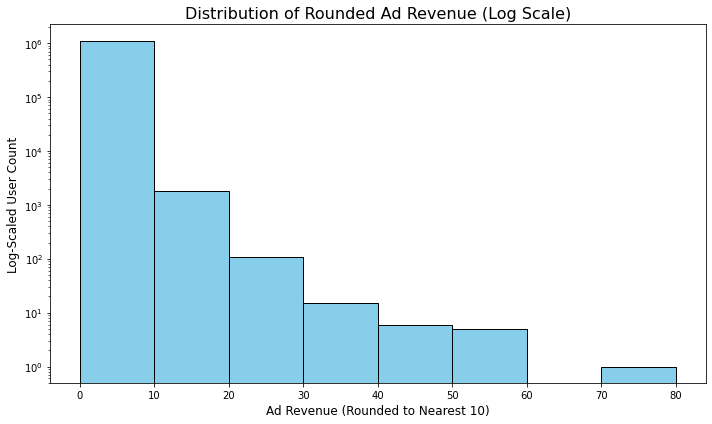

In [44]:
import matplotlib.pyplot as plt

# Checking if the log distrib seems logical
rounded_ad_revenue = round(df['ad_revenue'] / 10) * 10

plt.figure(figsize=(10, 6))
plt.hist(
    rounded_ad_revenue,
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80],
    color='skyblue',
    edgecolor='black'
)

# Set log scale on y-axis
plt.yscale('log')

# Titles and labels
plt.title('Distribution of Rounded Ad Revenue (Log Scale)', fontsize=16)
plt.xlabel('Ad Revenue (Rounded to Nearest 10)', fontsize=12)
plt.ylabel('Log-Scaled User Count', fontsize=12)

# Remove grid for clean look
plt.grid(False)

plt.tight_layout()
plt.show()

# indeed


## G. rv_revenue, rv_watched 
Noticing the both maximums are the same between ad and rv revenues, we dig deeper. The RV revenue is always below the ad revenue. I believe it is contained in it, meaning ad revenue is the sum of pop up ads and RV ads. We will not use the rv attributes, to avoid duplicity. 

In [45]:
print(f"there are {len(df[df['rv_revenue'].isna()])} null records in rv_revenue and {len(df[df['rv_watched'].isna()])} null recs in rv_watched")
print(f"the minimal value is {df['rv_revenue'].min()}, which is coherent. Max is {df['rv_revenue'].max()}")

# The maximum is the exact same value as before, we will check that the revenue columnis not a duplicate of the ad column 
mask = df['rv_revenue'].notnull()
df_filtered = df.loc[mask]
df_filtered["cd_eq"] = (df_filtered["rv_revenue"] == df_filtered["ad_revenue"])
df_filtered["cd_below"] = (df_filtered["rv_revenue"] <= df_filtered["ad_revenue"])
result = df_filtered["cd_eq"].value_counts()
print(result)
result_2 = df_filtered["cd_below"].value_counts()
print(result_2)
# They are different columns. 



there are 530809 null records in rv_revenue and 0 null recs in rv_watched
the minimal value is 0.0, which is coherent. Max is 78.76273159348477
False    410915
True     175927
Name: cd_eq, dtype: int64
True    586842
Name: cd_below, dtype: int64


C:\Users\loulo\AppData\Local\Temp\ipykernel_29576\2299510969.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["cd_eq"] = (df_filtered["rv_revenue"] == df_filtered["ad_revenue"])
C:\Users\loulo\AppData\Local\Temp\ipykernel_29576\2299510969.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["cd_below"] = (df_filtered["rv_revenue"] <= df_filtered["ad_revenue"])


## H. session_number
We are noticing that some sessions aree missing, since in the graph is not perfectly decresing. It might be because of very short sessions, or because there are missing data. 

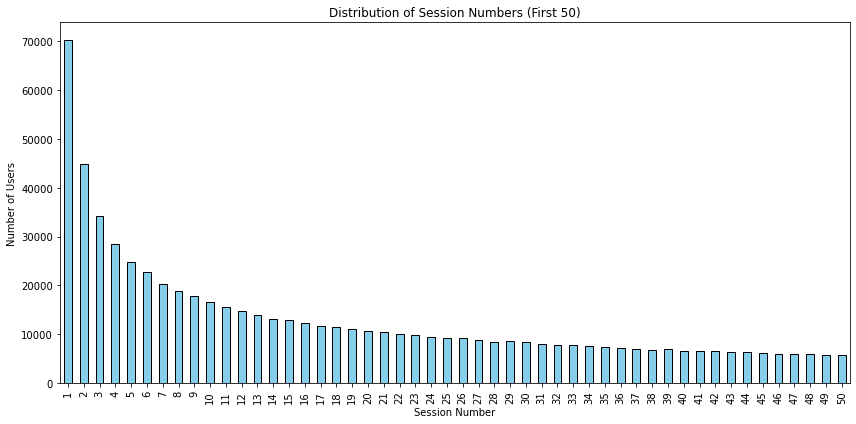

In [46]:
df['session_number'].value_counts().sort_index().head(50).plot(
    kind='bar',
    figsize=(12, 6),
    color='skyblue',
    edgecolor='black',
    title='Distribution of Session Numbers (First 50)'
)
plt.xlabel('Session Number')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()



## I. user_id
There are no missing or misformatted user_id

In [47]:
print(f"there are {len(df[df['user_id'].isna()])} null records in user_id, and {len(df['user_id'].value_counts())} distinct users out of {len(df)} records")


there are 0 null records in user_id, and 533833 distinct users out of 1117651 records


In [48]:
# We check if all users have valid uuid,  to clean out testers for instance which could have a different format
uuid_pattern = r'^[0-9a-fA-F]{8}-[0-9a-fA-F]{4}-[1-5][0-9a-fA-F]{3}-[89abAB][0-9a-fA-F]{3}-[0-9a-fA-F]{12}$'
df_uuid =  df.copy()
df_uuid['is_valid_uuid'] = df['user_id'].apply(lambda x: bool(re.match(uuid_pattern, str(x))))
invalid_uuids = df_uuid[~df_uuid['is_valid_uuid']]

# all users have valid uuid 
print(invalid_uuids)

Empty DataFrame
Columns: [country, first_app_launch_date, fs_revenue, fs_watched, game_count, iap_revenue, iap_transactions, install_store, manufacturer, model, open_at, platform, ad_revenue, rv_revenue, rv_watched, session_id, session_length, session_number, user_id, assigned_at, ab_test_name, cohort_name, is_valid_uuid]
Index: []

[0 rows x 23 columns]


## J. ab_test_name, cohort_name
There are 2 AB test running, on existing users and new users. 

In [50]:
print(f"there are {len(df[df['ab_test_name'].isna()])} null records in ab_test_name, and {len(df['ab_test_name'].value_counts())} distinct possibiliies like {df['ab_test_name'].value_counts()} ")
print(f"there are {len(df[df['cohort_name'].isna()])} null records in cohort_name, and {len(df['cohort_name'].value_counts())} distinct possibiliies like {df['cohort_name'].value_counts()} ")

there are 0 null records in ab_test_name, and 2 distinct possibiliies like v1.10 - Skipits - Existing Users    643617
v1.10 - Skipits - New Users         474034
Name: ab_test_name, dtype: int64 
there are 0 null records in cohort_name, and 3 distinct possibiliies like Control                    374663
Skipits - High Prices      372300
Skipits - Middle Prices    370688
Name: cohort_name, dtype: int64 


### i. Existing users 

In [52]:
df[df["ab_test_name"]=="v1.10 - Skipits - Existing Users"]['cohort_name'].value_counts()

Skipits - High Prices      214807
Control                    214603
Skipits - Middle Prices    214207
Name: cohort_name, dtype: int64

### ii. New users

In [53]:
df[df["ab_test_name"]=="v1.10 - Skipits - New Users"]['cohort_name'].value_counts()

Control                    160060
Skipits - High Prices      157493
Skipits - Middle Prices    156481
Name: cohort_name, dtype: int64